In [1]:
%pip install ..[tabular] --find-links "https://download.pytorch.org/whl/cpu/torch_stable.html"

Looking in links: https://download.pytorch.org/whl/cpu/torch_stable.html
Processing /home/ivsaav/Projects/pymdma
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pymdma: filename=pymdma-0.1.3-py3-none-any.whl size=119993 sha256=26d56d21f8fb58125f732521c11d4c7946e1f3461ffa81710ca809483042cad3
  Stored in directory: /tmp/pip-ephem-wheel-cache-rag110n0/wheels/36/8d/94/b27d660cfb0ef5aa96df13d5c4f6decb3e8f6102d1b59f2793
Successfully built pymdma
  Attempting uninstall: pymdma
    Found existing installation: pymdma 0.1.3
    Uninstalling pymdma-0.1.3:
      Successfully uninstalled pymdma-0.1.3
Note: you may need to restart the kernel to use updated packages.


## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, Callable, List
from scipy.stats import gaussian_kde
from sklearn.neighbors import NearestNeighbors
from matplotlib.offsetbox import AnchoredText

from sklearn.datasets import make_classification

## Auxiliary Functions

In [3]:
# Nearest Neighbor Model
def _get_nn_model(train: np.ndarray, distance_type: str = 'euclidean'):
    """
    Find nearest neighbors of test in train with first categoric_slice-many variables being categorical.

    :param train: train pandas dataframe
    :param cat_slice: where do category columns end

    :returns: scikit learn nearest_neighbor_model fit with train data

    """
    nearest_neighbor_model = NearestNeighbors(
        metric=distance_type,
        algorithm="ball_tree",
        n_jobs=None,
    )
    nearest_neighbor_model.fit(train)

    return nearest_neighbor_model


# Distances
def _get_nn_distances(
    tgt_emb: np.ndarray, 
    syn_emb: np.ndarray,
    distance_type: dict = 'euclidean',
    size: int = None
) -> Tuple[np.ndarray]:    
    # checkpoint
    assert tgt_emb.shape[1] == syn_emb.shape[1], \
    "Train and Syn have mismatched columns"

    # split into tgt_train, tgt_query, and syn_query
    if size is None:
        tgt_size, syn_size = len(tgt_emb), len(syn_emb)
    else:
        tgt_size, syn_size = size, size

    # train and query from target
    tgt_query = tgt_emb[-int(tgt_size):]

    # syn_train is not needed
    # if sample_size = synthetic_size, syn_query is all syn dataset
    syn_query = syn_emb[-int(syn_size) :]

    # training model
    nn_model = _get_nn_model(tgt_query, distance_type)

    # get nearest neighbors
    # target
    tgt_query_nn, _ = nn_model.kneighbors(tgt_query, n_neighbors=3)
    tgt_query_nn = tgt_query_nn[:, 1:]  # except the closest (itself)
    
    # synthetic
    syn_query_nn, _ = nn_model.kneighbors(syn_query, n_neighbors=2)

    # calculating DCR NNDR
    query_dict = {"tgt": tgt_query_nn, "syn": syn_query_nn}

    # compute privacy distances
    dcr, nndr = {}, {}
    for label, query in query_dict.items():
        # closest neighbor
        aux_dcr = query[:, 0]
        
        # normalized closest neighbor distances
        aux_nndr = aux_dcr / (query[:, 1] + 1e-10)  
        
        # assign
        dcr[label] = aux_dcr
        nndr[label] = aux_nndr
        
    return dcr, nndr


# Probability Density Function
def _get_nn_pdf(
    tgt_dist: np.ndarray, 
    syn_dist: np.ndarray,
) -> Tuple[np.ndarray]:
    
    # get distributions bins
    t_min, t_max = min(tgt_dist), max(tgt_dist)
    s_min, s_max = min(syn_dist), max(syn_dist)
    bins = np.linspace(
        min([t_min, s_min]), 
        max([t_max, s_max]), 
        600
    )

    # get distributions
    # tgt pdf dists
    pdf_tgt = gaussian_kde(
        tgt_dist
    ).pdf(bins)
    pdf_tgt /= sum(pdf_tgt)
    
    # syn pdf dists
    pdf_syn = gaussian_kde(
        syn_dist
    ).pdf(bins)
    pdf_syn /= sum(pdf_syn)
    
    return pdf_tgt, pdf_syn, bins


def subplot_dim_optm(dim: int):
    import math
    matrix_n, matrix_m = int(np.sqrt(dim)), int(np.sqrt(dim))
    matrix_n += math.ceil((dim - matrix_m ** 2) / matrix_n)
    return matrix_n, matrix_m

# Plot Generative Quality
def plot_generative_quality(
    real_data_list: List[np.ndarray],
    fake_data_list: List[np.ndarray],
    real_pdf_list: List[np.ndarray],
    fake_pdf_list: List[np.ndarray],
    bins_list: List[np.ndarray],
    names: List[str],
    emb_obj: Callable,
):
    # plot matrix dim
    n_dim, m_dim = subplot_dim_optm(dim=len(real_data_list))
    
    # figures
    fig1, axes_emb = plt.figure(n_dim, m_dim, figsize=(12, 8))
    fig2, axes_dist = plt.figure(n_dim, m_dim, figsize=(12, 8))

    # flatten axes array
    axes_emb = axes_emb.flatten()
    axes_dist = axes_dist.flatten()
    
    # loop
    for real_data, fake_data, real_pdf, fake_pdf, bins, name, ax_emb, ax_dist in zip(real_data_list, fake_data_list, real_pdf_list, fake_pdf_list, bins_list, names, axes_emb, axes_dist):
        # embeddings
        tgt_emb2d = emb_obj.transform(real_data)
        syn_emb2d = emb_obj.transform(fake_data)        
        
        ax_emb.scatter(
            tgt_emb2d[:, 0],
            tgt_emb2d[:, 1],
            color='forestgreen',
            marker='o',
            label='Real',
            alpha=0.7
        )
        ax_emb.scatter(
            syn_emb2d[:, 0],
            syn_emb2d[:, 1],
            color='darkred',
            marker='*',
            label='Fake',
            alpha=0.7
        )
        
        # set settings
        ax_emb.legend()
        ax_emb.set_xlabel('Embedding nr. 0')
        ax_emb.set_ylabel('Embedding nr. 1')

        # set title
        ax_emb.set_title(name)
        
        # distances plot        
        ax_dist.plot(
            bins,
            real_pdf,
            color='forestgreen',
            label='Real'
        )
        ax_dist.fill_between(bins, real_pdf, 0, color='forestgreen', alpha=.1)
        
        ax_dist.plot(
            bins,
            fake_pdf,
            color='darkred',
            label='Fake'
        )
        ax_dist.fill_between(bins, fake_pdf, 0, color='darkred', alpha=.1)
        
        # set settings
        ax_dist.legend()
        ax_dist.set_xlabel('Distances')
        ax_dist.set_ylabel('Relative Frequency')

        # set title
        ax_dist.set_title(name)

    # figures
    fig1.tight_layout()
    fig2.tight_layout()

    return fig1, fig2


def make_dataset(*args, **kwargs):
    # generated data
    X, y = make_classification(*args, **kwargs)

    # columns
    cols = [f"att_{idx}" for idx in range(X.shape[-1])]

    # dataframe conversion
    X_df = pd.DataFrame(X, columns=cols)
    X_df['tgt'] = y

    return X_df


# Plot datasets
def plot_datasets(
    dataset_list: List[np.ndarray],
    names: List[str],
    emb_obj: Callable,
    with_fit: bool = True,
    share_ax: bool = True,
):
    # plot matrix dim
    dim = len(dataset_list)
    n_dim, m_dim = subplot_dim_optm(dim=dim)
    
    # figures
    if share_ax:
        fig, axes = plt.subplots(n_dim, m_dim, figsize=(12, 8), sharex=True, sharey=True)
    else:
        fig, axes = plt.subplots(n_dim, m_dim, figsize=(12, 8))
    
    # flatten axes array
    axes = axes.flatten()

    # choose a color map
    colors = plt.cm.get_cmap('tab10', dim).colors
    
    # loop
    for dataset, name, color, ax in zip(dataset_list, names, colors, axes):
        # embeddings
        data_emb = emb_obj.fit_transform(dataset) if with_fit else emb_obj.transform(dataset)
        
        # scatter plot
        ax.scatter(
            data_emb[:, 0],
            data_emb[:, 1],
            facecolors=color,
            edgecolors=color,
            marker='o',
            alpha=0.7
        )
        
        # set settings
        ax.set_xlabel('Embedding nr. 0')
        ax.set_ylabel('Embedding nr. 1')

        # set title
        ax.set_title(name)

    # figures
    fig.tight_layout()

    # display
    fig.show()

    return fig

def _get_1d_pdf(data: np.ndarray, n_bins: int = 300):
    # get distributions bins
    d_min, d_max = min(data), max(data)
    bins = np.linspace(
        d_min, 
        d_max, 
        n_bins
    )

    # get distributions
    # tgt pdf dists
    pdf = gaussian_kde(
        data.astype(float)
    ).pdf(bins)
    pdf /= sum(pdf)
    
    return pdf, bins

def plot_kde(reference: np.ndarray, target_list: List[np.ndarray], column_names: List[str] = None, tag_names: List[str] = None, annots: np.ndarray = None):
    num_columns = reference.shape[1]
    num_datasets = len(target_list)
    
    # default feature names if not provided
    if column_names is None:
        column_names = [f"Col {i+1}" for i in range(reference.shape[-1])]

    if tag_names is None:
        tag_names = [f"Dataset {i+1}" for i in range(len(target_list))]
    
    # set up the plot grid
    fig, axes = plt.subplots(num_columns, num_datasets, figsize=(16, 10))
    
    for i in range(num_columns):
        # iterate through each feature (row in subplot grid)
        ref_pdf, ref_bins = _get_1d_pdf(reference[:, i], n_bins=400)

        # set ylabel        
        axes[i, 0].set_ylabel(column_names[i])

        # iterate
        for j, target in enumerate(target_list):
            # plot KDEs for each target dataset (columns in subplot grid)
            at = AnchoredText(str(annots[i, j]), prop=dict(size=7), frameon=False, loc='upper right')
            
            # target
            tgt_pdf, tgt_bins = _get_1d_pdf(target[:, i], n_bins=400)

            # plot the reference KDE on each row
            axes[i, j].plot(
                ref_bins,
                ref_pdf,
                color='forestgreen',
                label='Real',
                ls='--',
                alpha=.3
            )
            axes[i, j].fill_between(ref_bins, ref_pdf, 0, color='forestgreen', alpha=.1)

            # plot the target KDE on each row
            axes[i, j].plot(
                tgt_bins,
                tgt_pdf,
                color='indianred',
                label='Target',
                ls='--',
                alpha=.3
            )
            axes[i, j].fill_between(tgt_bins, tgt_pdf, 0, color='indianred', alpha=.1)

            # add annotation
            axes[i, j].add_artist(at)
            
            # window params
            if not i:
                axes[i, j].set_title(f'{tag_names[j]}')

            axes[i, j].set_yticks([])
            axes[i, j].set_xticks([])
            axes[i, j].grid()

    # display
    fig.tight_layout()
    fig.show()

    return fig

## Data Preparation

### Build Datasets

In [4]:
## Input validation
# A --> High Volume of Samples + Informative Features 
tag_in1 = 'A'
name_in1 = 'A - High Vol. + Inform.'
dataset_in1 = make_dataset(
    n_samples=2000,
    n_features=10,
    n_informative=10,
    n_repeated=0,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    weights=None,
    flip_y=0.01,
    shift=0.0,
    scale=3.0,
    shuffle=True,
    random_state=42
).to_numpy()

# B --> High Volume of Samples + Non-Informative Features
tag_in2 = 'B'
name_in2 = 'B - High Vol. + Non-Inform.'
dataset_in2 = make_dataset(
    n_samples=2000,
    n_features=10,
    n_informative=1,
    n_repeated=3,
    n_redundant=6,
    n_classes=2,
    n_clusters_per_class=1,
    weights=None,
    flip_y=0.01,
    shift=0.0,
    scale=3.0,
    shuffle=True,
    random_state=42
).to_numpy()

# C --> Small Volume of Samples + High Dimensionality + Informative Features
tag_in3 = 'C'
name_in3 = 'C - Small Vol. + Inform.'
dataset_in3 = make_dataset(
    n_samples=200,
    n_features=100,
    n_informative=95,
    n_repeated=2,
    n_redundant=3,
    n_classes=2,
    n_clusters_per_class=1,
    weights=None,
    flip_y=0.01,
    shift=0.0,
    scale=3.0,
    shuffle=True,
    random_state=42
).to_numpy()

# D --> Small Volume of Samples + High Dimensionality + Non-informative Features
tag_in4 = 'D'
name_in4 = 'D - Small Vol. + Non-Inform.'
dataset_in4 = make_dataset(
    n_samples=200,
    n_features=100,
    n_informative=1,
    n_repeated=0,
    n_redundant=99,
    n_classes=2,
    n_clusters_per_class=1,
    weights=None,
    flip_y=0.01,
    shift=0.0,
    scale=3.0,
    shuffle=True,
    random_state=42
).to_numpy()

## Synthesis Evaluation
# reference dataset
tag_ref = 'R'
name_ref = 'R - Reference Dataset'
dataset_ref = make_dataset(
    n_samples=2000,
    n_features=10,
    n_informative=5,
    n_repeated=2,
    n_redundant=3,
    n_classes=2,
    n_clusters_per_class=1,
    weights=None,
    flip_y=0.01,
    shift=0.0,
    scale=3.0,
    shuffle=True,
    random_state=42
).to_numpy()

# A --> random dataset
tag_syn1 = 'A'
name_syn1 = 'A - Random'
dataset_s1 = np.random.random(dataset_ref.shape) * 3.0

# B --> cumulative small distortion
tag_syn2 = 'B'
name_syn2 = 'B - Small Add Distortion'
rnd = np.random.random(dataset_ref.shape) * 0.01
dataset_s2 = np.copy(dataset_ref) + rnd

# C --> cumulative large distortion
tag_syn3 = 'C'
name_syn3 = 'C - Large Add Distortion'
rnd = np.random.random(dataset_ref.shape) * 100
dataset_s3 = np.copy(dataset_ref) + rnd

# D --> small multiplicative distortion
tag_syn4 = 'D'
name_syn4 = 'D - Small Mult. Distortion'
rnd = 0.7
dataset_s4 = np.copy(dataset_ref) * rnd

# E --> large multiplicative distortion
tag_syn5 = 'E'
name_syn5 = 'E - Large Mult. Distortion'
rnd = 100
dataset_s5 = np.copy(dataset_ref) * rnd

### Plot Datasets

/home/ivsaav/Projects/pymdma/.venv-dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_275949/3535142853.py:233: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', dim).colors
/tmp/ipykernel_275949/3535142853.py:261: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


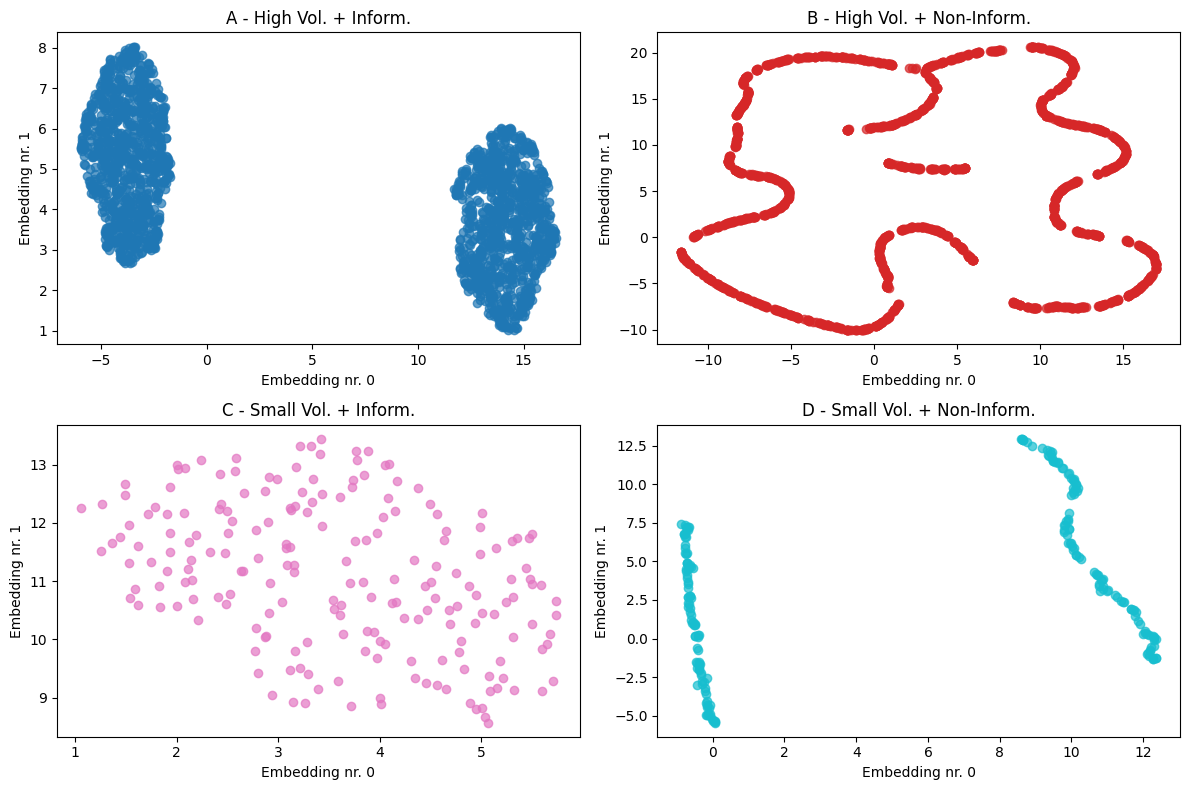

In [5]:
from pymdma.tabular.embeddings.embed import UMAPEmbedder
from pymdma.tabular.embeddings.scale import StandardNorm

# umap embedder
emb_obj = UMAPEmbedder(n_components=2)

# Z-score scaler
scale_obj = StandardNorm()

# input validation
dataset_list = [dataset_in1, dataset_in2, dataset_in3, dataset_in4]
dataset_norm = list(map(lambda x: scale_obj.fit_transform(x), dataset_list))
names = [name_in1, name_in2, name_in3, name_in4]

# plot 
_ = plot_datasets(dataset_norm, names, emb_obj, with_fit=True, share_ax=False)

/tmp/ipykernel_275949/3535142853.py:233: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', dim).colors
/tmp/ipykernel_275949/3535142853.py:261: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


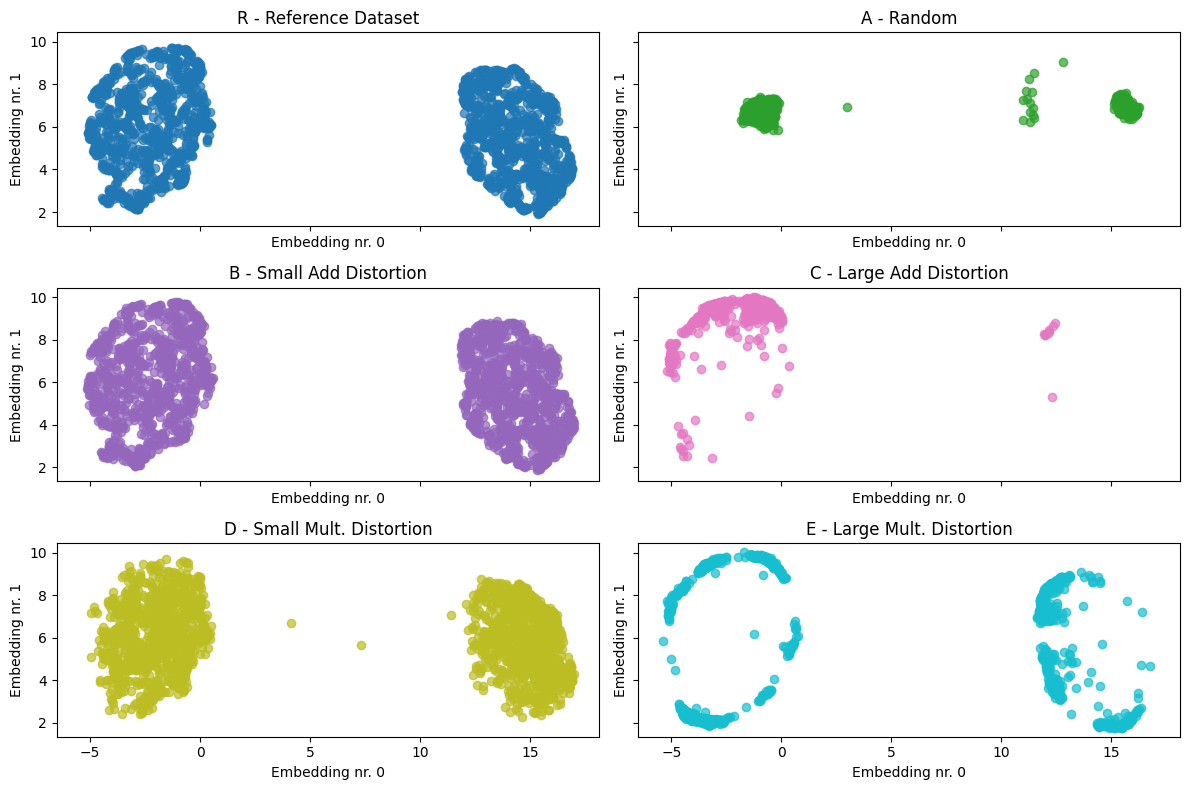

In [6]:
from pymdma.tabular.embeddings.embed import UMAPEmbedder
from pymdma.tabular.embeddings.scale import StandardNorm

# reference dataset
ref = np.copy(dataset_ref)

# normalizer
# Z-score scaler
scale_obj = StandardNorm()

# fit with reference data
ref = scale_obj.fit_transform(ref)

# embedder
# umap embedder
emb_obj = UMAPEmbedder(n_components=2)

# fit with reference data
emb_obj.fit(ref)

# input validation
dataset_list = [dataset_ref, dataset_s1, dataset_s2, dataset_s3, dataset_s4, dataset_s5]
dataset_norm = list(map(lambda x: scale_obj.transform(x), dataset_list))
names = [name_ref, name_syn1, name_syn2, name_syn3, name_syn4, name_syn5]

# plot 
_ = plot_datasets(dataset_norm, names, emb_obj, with_fit=False, share_ax=True)

## Input Validation

In the tabular modality, the pymdma package provides one type of input validation:
- **no-reference**: The tabular dataset is validated without any reference set of data.

This section will demonstrate how to use some of the input validation metrics provided.

### No Reference Evaluation

### Get Datasets

In [7]:
# Datasets
# input validation
dataset_list = [dataset_in1, dataset_in2, dataset_in3, dataset_in4]
names = [name_in1, name_in2, name_in3, name_in4]
tag_list = [tag_in1, tag_in2, tag_in3, tag_in4]

### Privacy

/tmp/ipykernel_275949/3535142853.py:233: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', dim).colors
/tmp/ipykernel_275949/3535142853.py:261: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


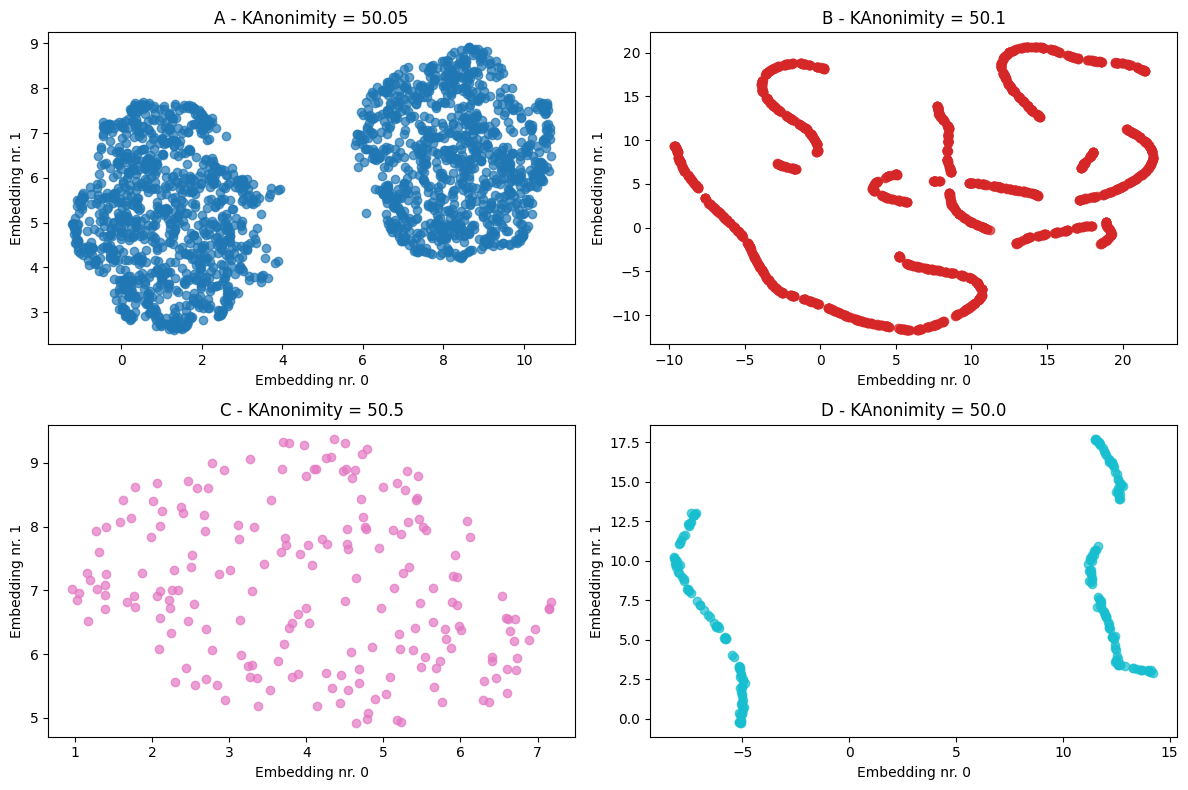

In [8]:
from pymdma.tabular.measures.input_val import KAnonymityScore
from pymdma.tabular.embeddings.embed import UMAPEmbedder

# umap embedder
emb_obj = UMAPEmbedder(n_components=2)

# privacy
score_name = 'KAnonimity'
k_anom = KAnonymityScore(column_names=None, qi_names=None)  # K-anonimity

# score list
scores = []

# compute scores
for dataset, tag in zip(dataset_list, tag_list):
    # compute
    aux_score = round(k_anom.compute(dataset).value[0], 2)

    # append
    scores.append(f"{tag} - {score_name} = {aux_score}")
    

# plot 
_ = plot_datasets(dataset_list, scores, emb_obj, with_fit=True, share_ax=False)

### Quality

/home/ivsaav/Projects/pymdma/.venv-dev/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/tmp/ipykernel_275949/3535142853.py:233: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', dim).colors
/tmp/ipykernel_275949/3535142853.py:261: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


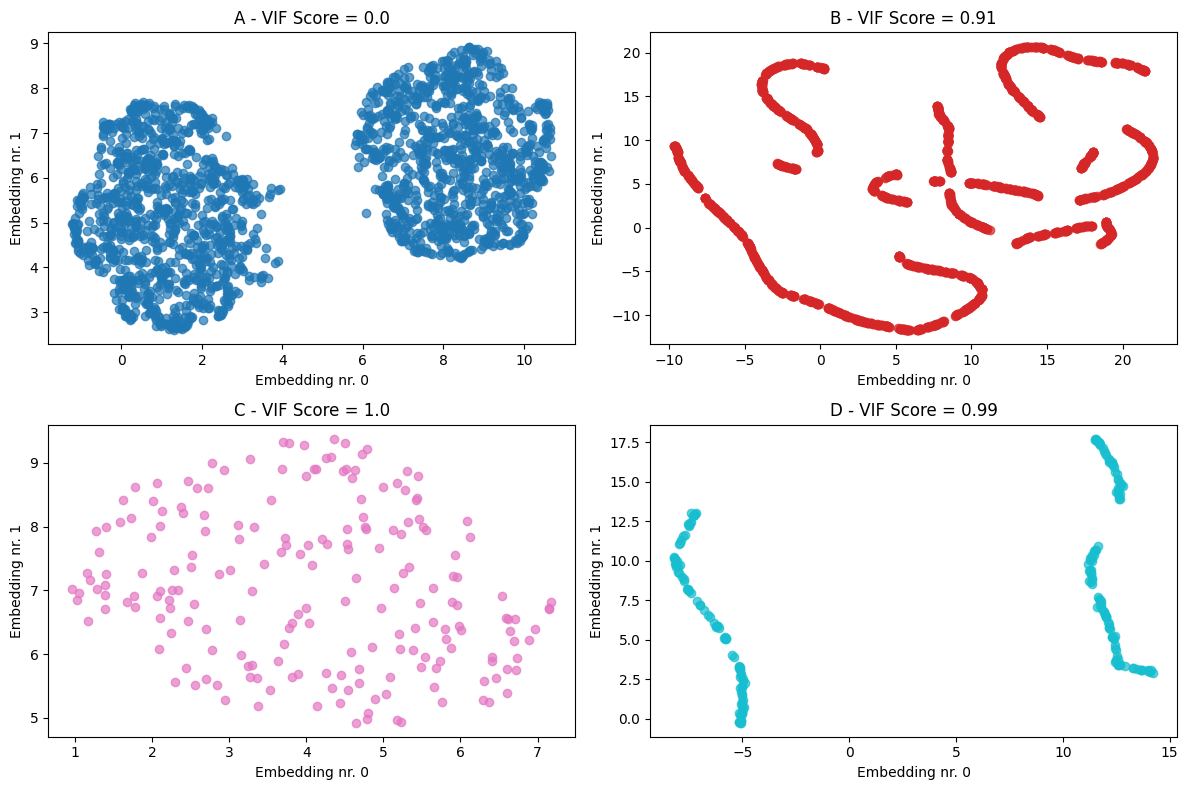

In [9]:
from pymdma.tabular.measures.input_val import VIFactorScore
from pymdma.tabular.embeddings.embed import UMAPEmbedder

# umap embedder
emb_obj = UMAPEmbedder(n_components=2)

# quality
score_name = 'VIF Score'
vif = VIFactorScore(column_names=None)  # VIF

# score list
scores = []

# compute scores
for dataset, tag in zip(dataset_list, tag_list):
    # compute
    aux_score = round(vif.compute(dataset).value[0], 2)

    # append
    scores.append(f"{tag} - {score_name} = {aux_score}")
    

# plot 
_ = plot_datasets(dataset_list, scores, emb_obj, with_fit=True, share_ax=False)

/tmp/ipykernel_275949/3535142853.py:233: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', dim).colors
/tmp/ipykernel_275949/3535142853.py:261: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


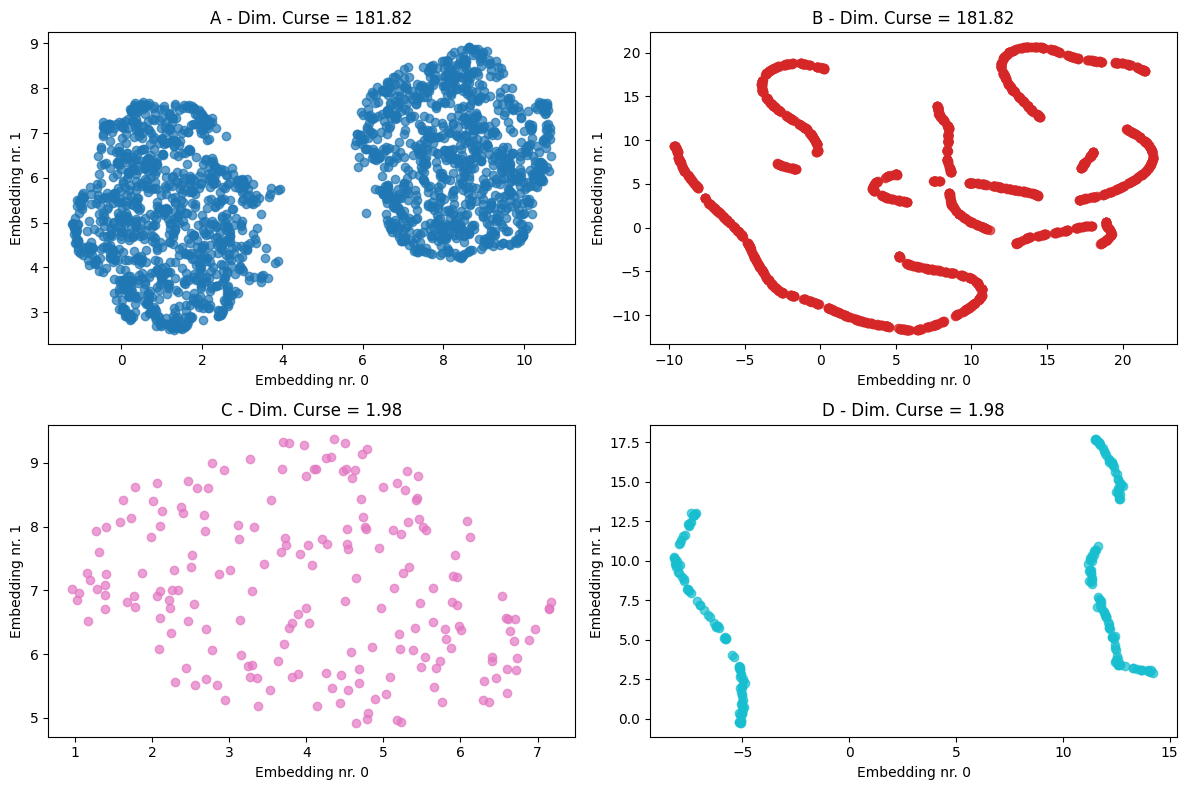

In [10]:
from pymdma.tabular.measures.input_val import DimCurseScore
from pymdma.tabular.embeddings.embed import UMAPEmbedder

# umap embedder
emb_obj = UMAPEmbedder(n_components=2)

# quality
score_name = 'Dim. Curse'
dimc = DimCurseScore()  # Dimensionality Curse

# score list
scores = []

# compute scores
for dataset, tag in zip(dataset_list, tag_list):
    # compute
    aux_score = round(dimc.compute(dataset).value[0], 2)

    # append
    scores.append(f"{tag} - {score_name} = {aux_score}")
    

# plot 
_ = plot_datasets(dataset_list, scores, emb_obj, with_fit=True, share_ax=False)

/tmp/ipykernel_275949/3535142853.py:233: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', dim).colors
/tmp/ipykernel_275949/3535142853.py:261: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


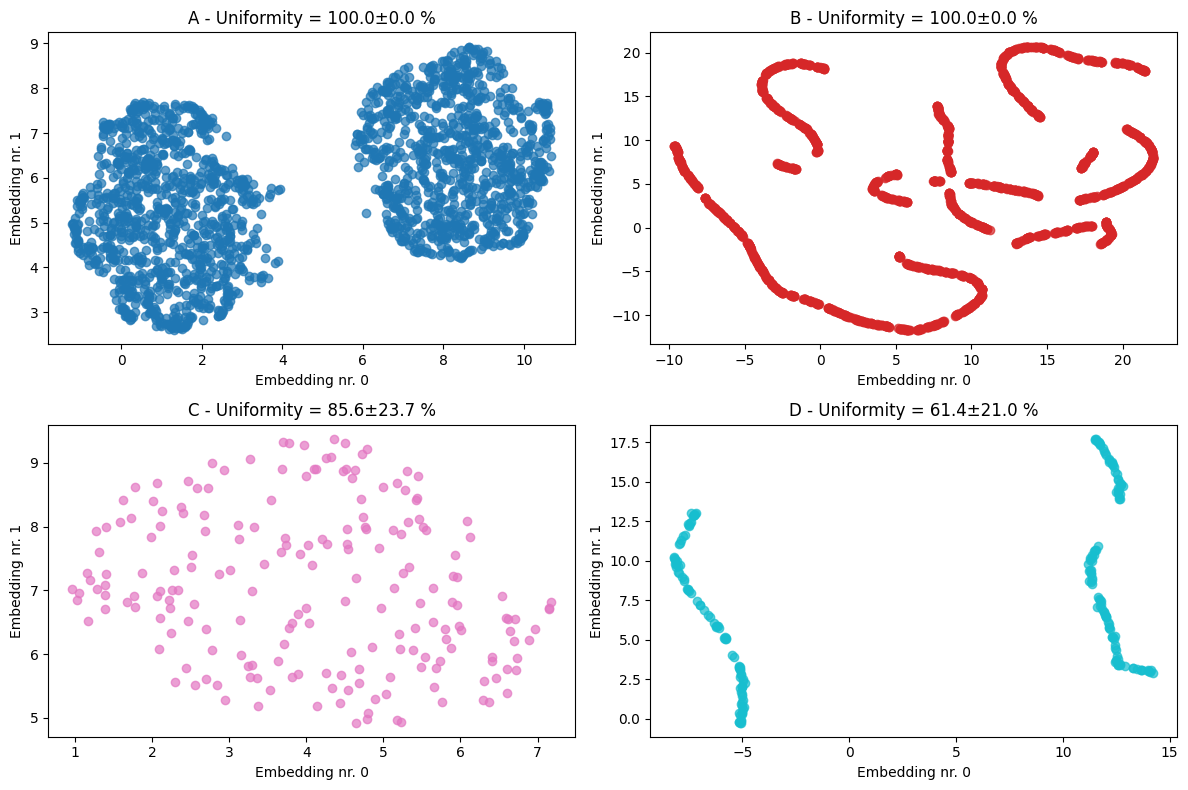

In [11]:
from pymdma.tabular.measures.input_val import UniformityScore
from pymdma.tabular.embeddings.embed import UMAPEmbedder

# umap embedder
emb_obj = UMAPEmbedder(n_components=2)

# quality
score_name = 'Uniformity'
unif = UniformityScore(column_names=None)  # Uniformity

# score list
scores = []

# compute scores
for dataset, tag in zip(dataset_list, tag_list):
    # compute
    aux_score = list(unif.compute(dataset).stats[0].values())

    # append
    scores.append(
        f"{tag} - {score_name} = " +
        f"{round(aux_score[0], 1)}" +
        u'\u00B1' + 
        f"{round(aux_score[1], 1)} %"
    )

# plot 
_ = plot_datasets(dataset_list, scores, emb_obj, with_fit=True, share_ax=False)

/tmp/ipykernel_275949/3535142853.py:233: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', dim).colors
/tmp/ipykernel_275949/3535142853.py:261: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


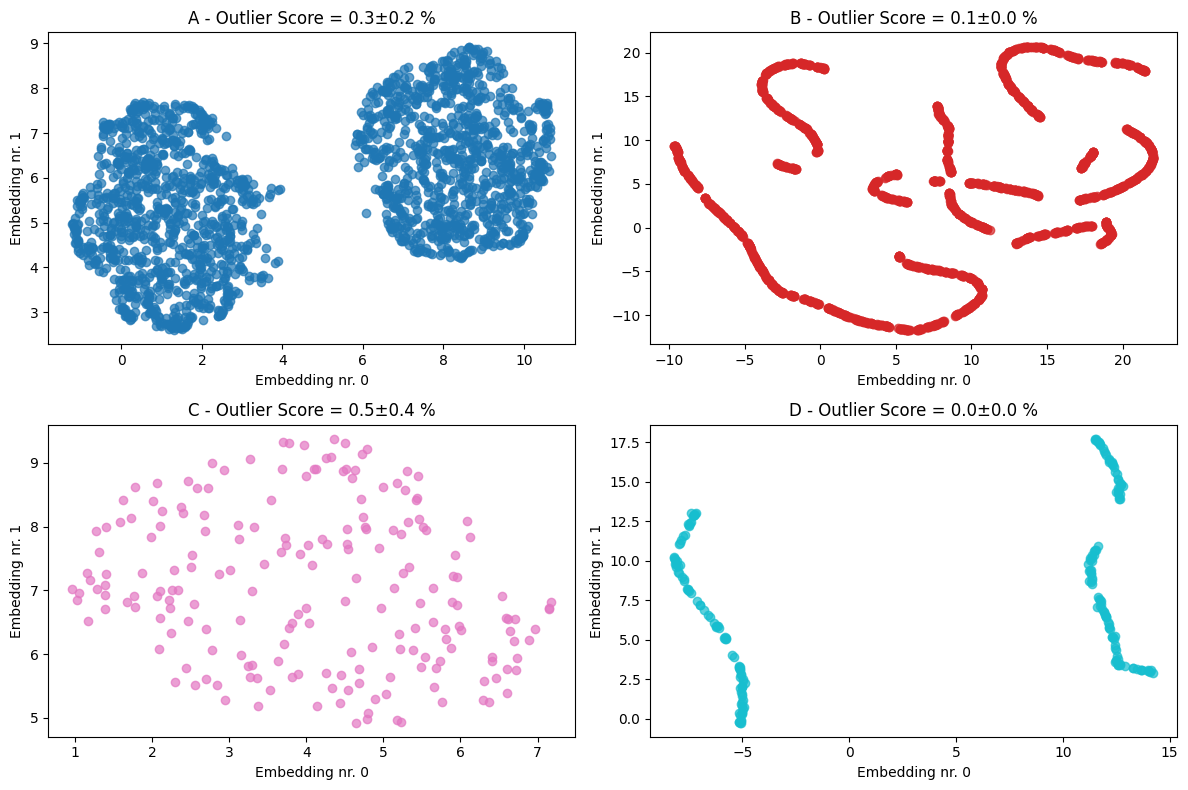

In [12]:
from pymdma.tabular.measures.input_val import OutlierScore
from pymdma.tabular.embeddings.embed import UMAPEmbedder

# umap embedder
emb_obj = UMAPEmbedder(n_components=2)

# quality
score_name = 'Outlier Score'
outl = OutlierScore()  # Outliers

# score list
scores = []

# compute scores
for dataset, tag in zip(dataset_list, tag_list):
    # compute
    aux_score = list(outl.compute(dataset).stats[0].values())

    # append
    scores.append(
        f"{tag} - {score_name} = " +
        f"{round(aux_score[0], 1)}" +
        u'\u00B1' + 
        f"{round(aux_score[1], 1)} %"
    )
    
# plot 
_ = plot_datasets(dataset_list, scores, emb_obj, with_fit=True, share_ax=False)

## Synthetic Validation

The automatic evaluation of synthetically generated tabular data is a common practice in the field of generative AI, and is crucial for the assessment of the quality of large synthetic datasets. This is usually done by comparing the synthetic records to a set of reference records by considering the similarity between the distributions of the two sets. 

In this section, we will demonstrate how to use the `pymdma` package to evaluate the quality of synthetic tabular data.

### Get datasets

In [13]:
# Datasets
# input validation
dataset_list = [dataset_ref, dataset_s1, dataset_s2, dataset_s3, dataset_s4, dataset_s5]  # target dataset list
ref = np.copy(dataset_ref)  # reference dataset
names = [name_ref, name_syn1, name_syn2, name_syn3, name_syn4, name_syn5]  # dataset names
tag_list = [tag_ref, tag_syn1, tag_syn2, tag_syn3, tag_syn4, tag_syn5]  # dataset tags

### Data Preparation

In [14]:
from pymdma.tabular.embeddings.embed import UMAPEmbedder
from pymdma.tabular.embeddings.scale import StandardNorm

# Z-score scaling
scale_obj = StandardNorm()

# fit with reference data
ref = scale_obj.fit_transform(ref)

# umap embedder
emb_obj = UMAPEmbedder(n_components=2)

# fit with reference data
emb_obj.fit(ref)

In [15]:
# normalize the list of datasets for evaluation
dataset_norm_list = [scale_obj.transform(dset) for dset in dataset_list]

### Metric Examples

#### Precision + Recall + Authenticity + Coverage

/tmp/ipykernel_275949/3535142853.py:233: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', dim).colors
/tmp/ipykernel_275949/3535142853.py:261: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


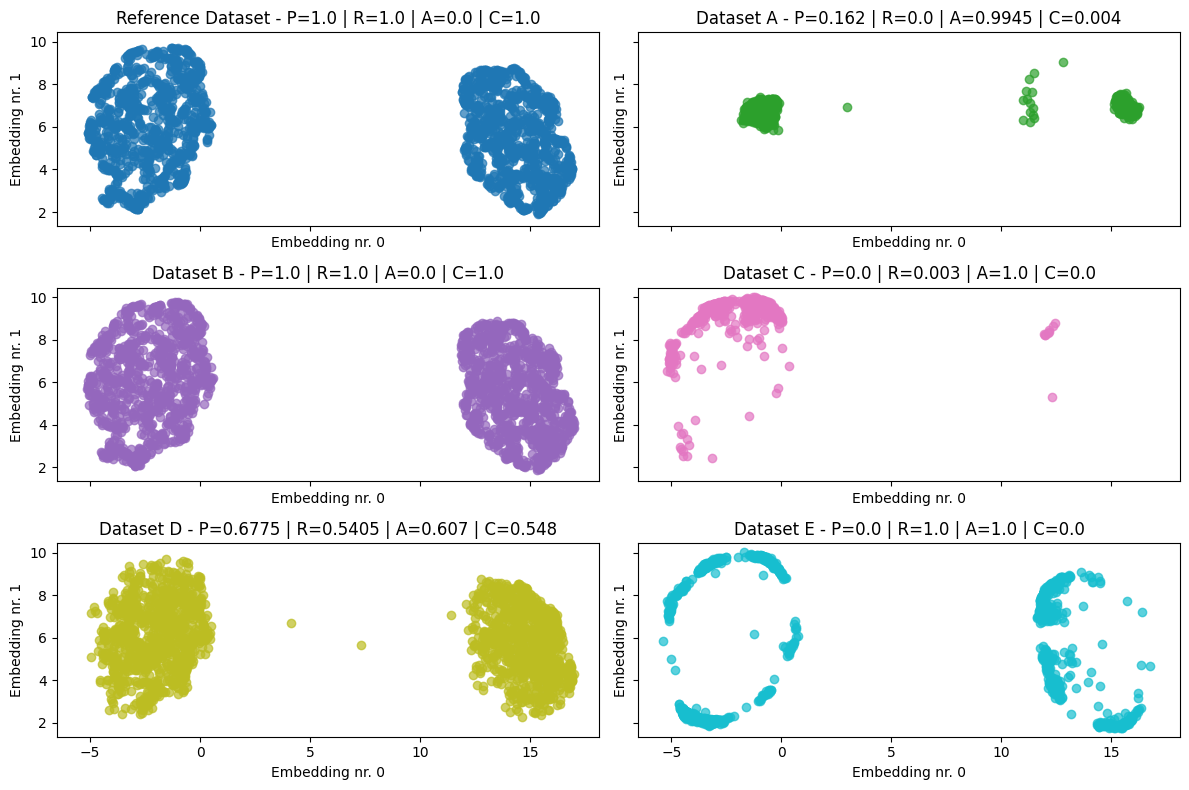

In [16]:
from pymdma.tabular.measures.synthesis_val import ImprovedPrecision, ImprovedRecall, Authenticity, Coverage

ip, ip_name = ImprovedPrecision(k=5), "P"
ir, ir_name = ImprovedRecall(k=5), "R"
aut, aut_name = Authenticity(k=5), "A"
cov, cov_name = Coverage(k=5), "C"

# score list
scores = []

# compute scores
for dataset, tag in zip(dataset_norm_list, tag_list):
    # compute
    precision = ip.compute(ref, dataset).value[0]
    recall = ir.compute(ref, dataset).value[0]
    autenticity = aut.compute(ref, dataset).value[0]
    coverage = cov.compute(ref, dataset).value[0]

    # aggregate all scores
    aux_scores = [precision, recall, autenticity, coverage]
    aux_names = [ip_name, ir_name, aut_name, cov_name]

    # get score in string format
    score_s = " | ".join([f"{name}={score}" for name, score in zip(aux_names, aux_scores)])

    # assign
    if tag != tag_ref:
        # append
        scores.append(f"Dataset {tag} - {score_s}")
    else:
        # append
        scores.append(f"Reference Dataset - {score_s}")
    

# plot
_ = plot_datasets(dataset_norm_list, scores, emb_obj, with_fit=False, share_ax=True)

#### Statistical Similarity + Correlation Coherence + Distance to Closest Record

/tmp/ipykernel_275949/3535142853.py:233: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', dim).colors
/tmp/ipykernel_275949/3535142853.py:261: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


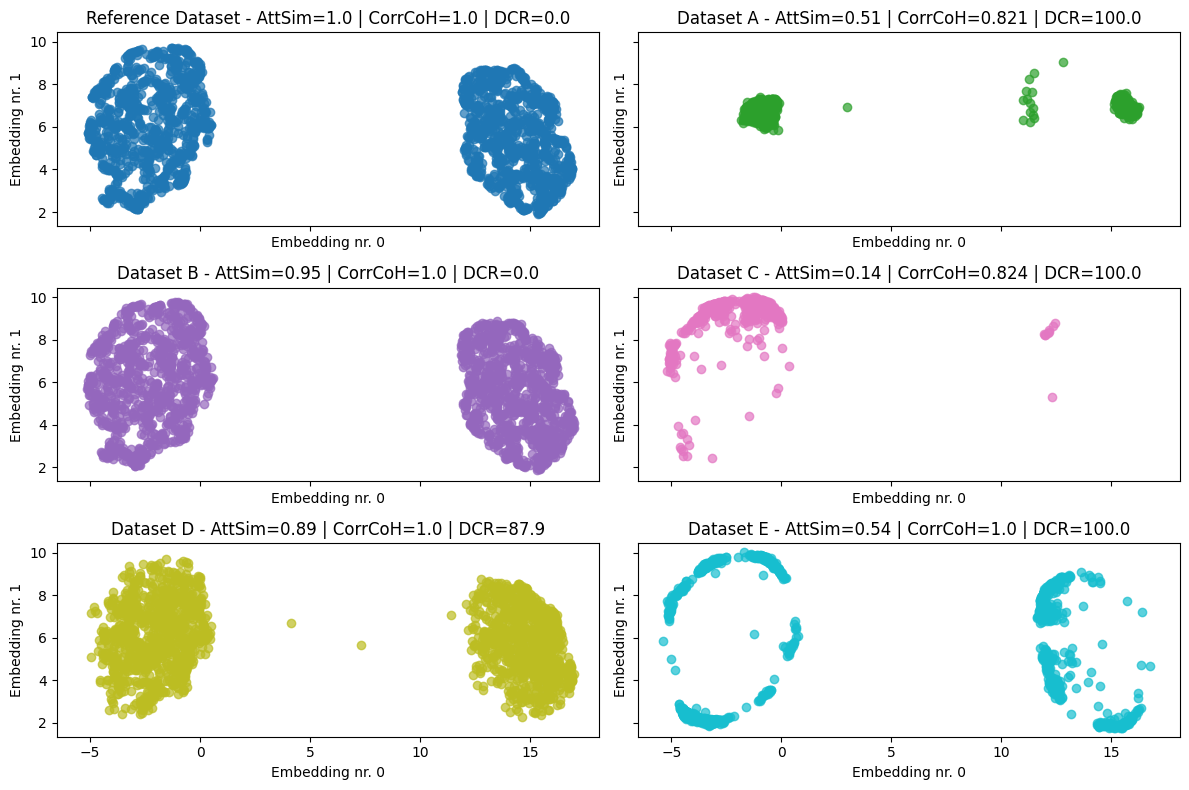

In [17]:
from pymdma.tabular.measures.synthesis_val import StatisticalSimScore, CoherenceScore
from pymdma.tabular.measures.synthesis_val import DCRPrivacy

ssim, ssim_name = StatisticalSimScore(), "AttSim"
coher, coher_name = CoherenceScore(weights=None, corr_type='pearson'), "CorrCoH"
dcr, dcr_name = DCRPrivacy(distance_type='euclidean'), "DCR"

# score list
scores = []

# compute scores
for dataset, tag in zip(dataset_norm_list, tag_list):
    # compute
    ssim_score = ssim.compute(ref, dataset).stats[0].get('mean')
    coher_score = coher.compute(ref, dataset).value[0]
    dcr_score = dcr.compute(ref, dataset).value[0].get('privacy')

    # aggregate all scores
    aux_scores = [ssim_score, coher_score, dcr_score]
    aux_names = [ssim_name, coher_name, dcr_name]

    # get score in string format
    score_s = " | ".join([f"{name}={score}" for name, score in zip(aux_names, aux_scores)])

    # assign
    if tag != tag_ref:
        # append
        scores.append(f"Dataset {tag} - {score_s}")
    else:
        # append
        scores.append(f"Reference Dataset - {score_s}")
    

# plot
_ = plot_datasets(dataset_norm_list, scores, emb_obj, with_fit=False, share_ax=True)

#### Statistical Divergence Score (1D)

/home/ivsaav/Projects/pymdma/.venv-dev/lib/python3.12/site-packages/pymdma/tabular/measures/utils_syn.py:348: RuntimeWarning: divide by zero encountered in log
  np.where(real_pdf != 0, real_pdf * np.log(real_pdf / (syn_pdf + eps)), 0),
/home/ivsaav/Projects/pymdma/.venv-dev/lib/python3.12/site-packages/pymdma/tabular/measures/utils_syn.py:348: RuntimeWarning: invalid value encountered in multiply
  np.where(real_pdf != 0, real_pdf * np.log(real_pdf / (syn_pdf + eps)), 0),
/tmp/ipykernel_275949/3535142853.py:347: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


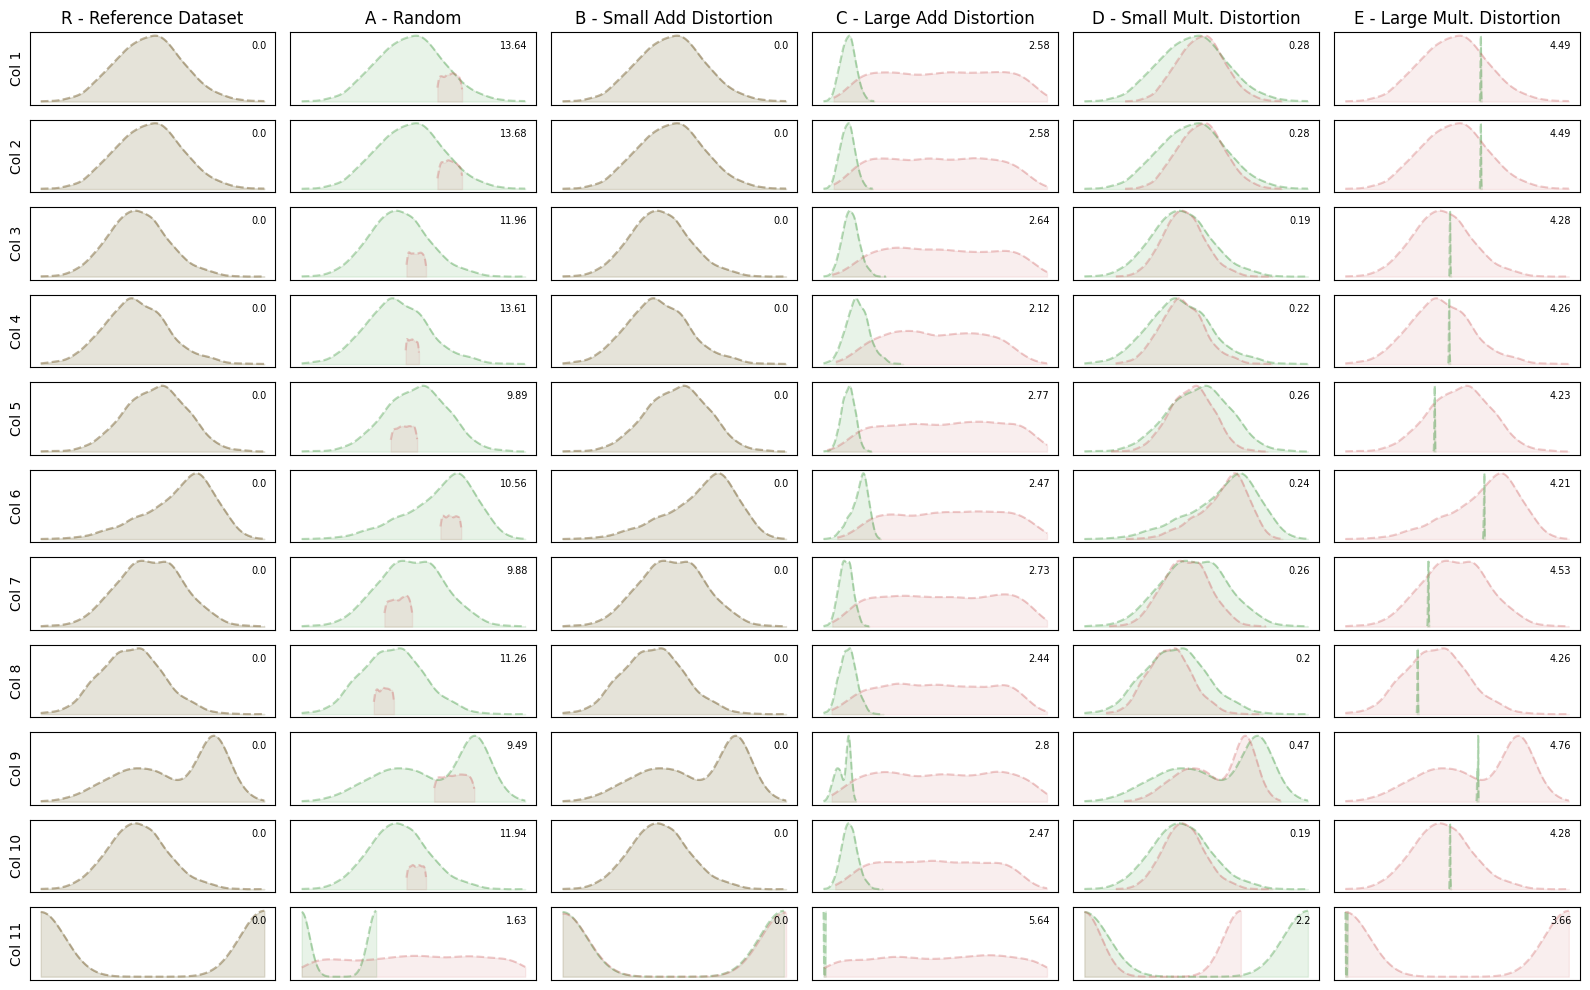

In [18]:
from pymdma.tabular.measures.synthesis_val import StatisiticalDivergenceScore

# statistical similarity
sdiv, sdiv_name = StatisiticalDivergenceScore(), "StatDiv"

# score list
scores = []

# compute scores
for dataset, tag in zip(dataset_norm_list, tag_list):
    # compute
    ssim_score = sdiv.compute(ref, dataset).value[0]
    ssim_score = list(ssim_score.values())

    # append
    scores.append(ssim_score)

# transpose
scores_np = np.array(scores).T.round(2).squeeze(0)

# plot
fig = plot_kde(reference=ref, target_list=dataset_norm_list, tag_names=names, annots=scores_np)